# Linear Model Selection and Regularization

## Lab 1: Subset Selecton Methods


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score
sns.set()

from sklearn.preprocessing import StandardScaler



%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [8]:
hitters = pd.read_csv("data/hitters.csv")
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [9]:
hitters.isna().any()
##there are some missing values in the salary. The book suggests to omit those rows.

Unnamed: 0    False
AtBat         False
Hits          False
HmRun         False
Runs          False
RBI           False
Walks         False
Years         False
CAtBat        False
CHits         False
CHmRun        False
CRuns         False
CRBI          False
CWalks        False
League        False
Division      False
PutOuts       False
Assists       False
Errors        False
Salary         True
NewLeague     False
dtype: bool

In [10]:
hitters.dropna(inplace=True)
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


In [11]:
hitters.info()
# There are several categorical data in the dataset. At this statge we are going to ingore the first 
#column Unamed and will concentrate only on League, Division, NewLeague 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


In [12]:
# Let's take each categorical feature separately and analyse it.
print(np.unique(hitters['League']))
print(np.unique(hitters['Division']))
print(np.unique(hitters['NewLeague']))

# Each of the categorical featurea have 2 distinct categories. 
#For each of them we will add a separate binary column and will remove the original categorical fatures.

['A' 'N']
['E' 'W']
['A' 'N']


In [13]:
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [14]:
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
hitters.head(2)

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,632,43,10,475.0,1,1,1
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,880,82,14,480.0,0,1,0


In [15]:
## these variables will also be used in Lab2 and Lab3
X = hitters.iloc[:,1:].drop("Salary", axis=1)
y = hitters['Salary']

In [16]:
def generate_models(nr, X, y):
    
    comb_features = combinations(list(X.columns),nr)
    models = []
    for feature in comb_features:
        X_select = " + ".join(feature)
        formula = "Salary ~ {}".format(X_select)
        model = smf.ols(formula, data = pd.concat([X,y],axis=1)).fit()
        #Save the result
        models +=[(formula,model)]
    return models


def max_adjr2(models):
    "sorts the R-square values of the models and selects the highest value "
    return sorted(models, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_rss(models):
    "Returns the lowest RSS score"
    return sorted(models, key=lambda tup: tup[1].ssr)[0]

In [17]:
# Let's see all the possible combinations of 2 variables
models_2 = generate_models(2,X,y)
print(max_adjr2(models_2))
print(min_rss(models_2))

# the result is similar to that from the book. For higher values than 2 it will take much much longer

('Salary ~ Hits + CRBI', <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f712825c1d0>)
('Salary ~ Hits + CRBI', <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f712825c1d0>)


### Forward and Backward Stepwise Selection

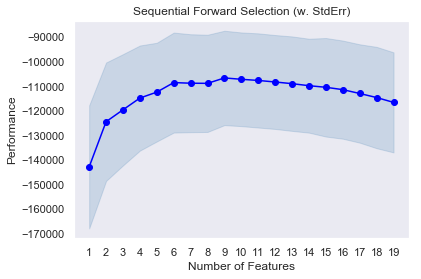


Sequential Forward Selection:
['AtBat', 'Hits', 'Walks', 'Years', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Division_W']
CV Score:
-106654.3740780645


In [18]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

lr = LinearRegression()

sfs = SFS(lr, 
          k_features=(1,len(X.columns)), 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X.values, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

print('\nSequential Forward Selection:')
print(X.columns[list(sfs.k_feature_idx_)].tolist())
print('CV Score:')
print(sfs.k_score_)


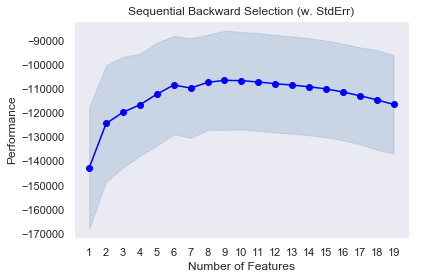


Sequential Backward Selection:
['AtBat', 'Hits', 'Walks', 'CAtBat', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Division_W']
CV Score:
-106618.8819992942


In [19]:
lr = LinearRegression()
sbs = SFS(lr, 
          k_features=(1,len(X.columns)), 
          forward=False, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sbs = sbs.fit(X.values, y)
fig = plot_sfs(sbs.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

print('\nSequential Backward Selection:')
print(X.columns[list(sbs.k_feature_idx_)].tolist())
print('CV Score:')
print(sbs.k_score_)

Both graphs show that after 9th feature the performance of the models decreases.

## Lab 2. Ridge Regression and Lasso

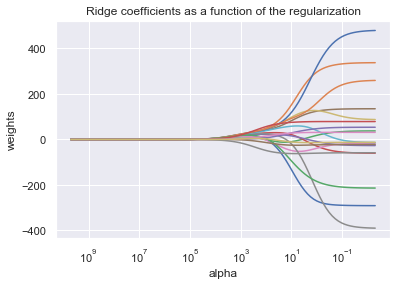

In [20]:
alphas = 10**np.linspace(10,-2,100)*0.5

scaler = StandardScaler()
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scaler.fit_transform(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

scaler = StandardScaler()

In [22]:
# for alpha equal to 4

ridge = Ridge(alpha=4)
ridge.fit(scaler.fit_transform(X_train), y_train)
y_pred = ridge.predict(scaler.transform(X_test))
mean_squared_error(y_test, y_pred)



143289.20828369056

In [23]:
# for alpha equal to 10**10
ridge.set_params(alpha=10**10)
ridge.fit(scaler.fit_transform(X_train), y_train)
y_pred = ridge.predict(scaler.fit_transform(X_test))
mean_squared_error(y_test, y_pred)

234806.58145287237

In [24]:
# finding the optimal alpha using CV
ridgecv = RidgeCV(alphas=alphas,cv=10, scoring='neg_mean_squared_error')
ridgecv.fit(scaler.fit_transform(X_train), y_train)
ridgecv.alpha_

87.37642000038414

In [25]:
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scaler.fit_transform(X_train), y_train)
mean_squared_error(y_test, ridge.predict(scaler.fit_transform(X_test)))

144900.21497957222

In [26]:
pd.Series(ridge.coef_, index=X.columns)

AtBat          29.477228
Hits           56.279960
HmRun          23.648957
Runs           32.490770
RBI            24.695918
Walks          19.833172
Years          24.424094
CAtBat         23.855736
CHits          33.500665
CHmRun         22.615371
CRuns          32.254675
CRBI           31.973516
CWalks          6.069129
PutOuts        43.502428
Assists        -0.351618
Errors        -11.806846
League_N       21.406504
Division_W    -22.245220
NewLeague_N    11.676608
dtype: float64

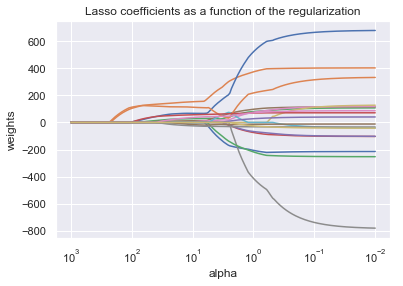

In [27]:
## Similar analysis for Lasso

lasso = Lasso(max_iter=10000)
alphas = np.logspace(3, -2, 200)
coefs = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(scaler.fit_transform(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [28]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scaler.fit_transform(X_train), y_train)



LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [29]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scaler.fit_transform(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scaler.fit_transform(X_test)))

142569.57893518047

In [30]:
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits           148.941221
HmRun           26.121066
Runs             0.000000
RBI              0.000000
Walks           11.192221
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns           66.832372
CRBI           114.874323
CWalks           0.000000
PutOuts         54.339682
Assists         -0.000000
Errors         -10.569044
League_N        31.139290
Division_W     -21.563331
NewLeague_N      0.000000
dtype: float64

## Lab 3. PCR and PLS Regression

In [31]:
pca = PCA()
X_modified = pca.fit_transform(scaler.fit_transform(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]


(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


In [33]:
#Explained variance by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

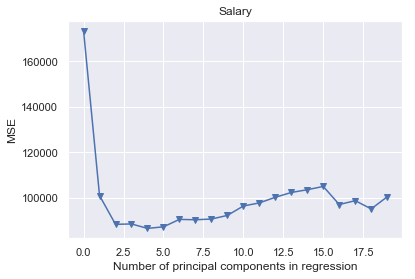

In [37]:
## working with training data

pca2 = PCA()
X_mod_train = pca2.fit_transform(scaler.fit_transform(X_train))
n = len(X_mod_train)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_mod_train[:,:i], y_train.ravel(), cv=10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The plot indicates that the lowest training MSE is somewhere at 4 components.

In [38]:
X_mod_test = pca2.transform(scaler.transform(X_test))[:,:5]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_mod_train[:,:5], y_train)

# Prediction with test data
y_pred = regr.predict(X_mod_test)
mean_squared_error(y_test, y_pred)

151162.9335230489

(-1, 19.9)

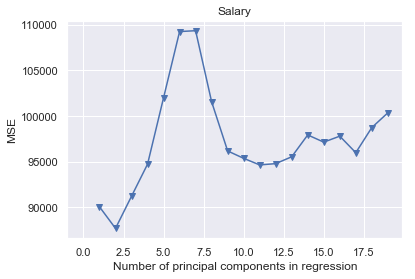

In [39]:
#### Partial Least Squares 

n = len(X_train)
mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scaler.fit_transform(X_train), y_train, cv=10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)



In [40]:
pls = PLSRegression(n_components=2)
pls.fit(scaler.fit_transform(X_train), y_train)

mean_squared_error(y_test, pls.predict(scaler.fit_transform(X_test)))

150599.59883817157

## Applied

In [41]:
##   8

np.random.seed(231)
X = np.random.randn(100)
eps = np.random.randn(100)

In [42]:
beta0, beta1, beta2, beta3 = -5, 1, 4, 3
y = beta0 + beta1 * X + beta2 * X ** 2 + beta3 * X ** 3 + eps
df = pd.DataFrame({'X1': X, 'X2': X ** 2, 'X3': X**3, 'X4': X**4,'X5': X**5,
                   'X6': X**6,'X7': X**7,'X8': X**8,'X9': X**9,'X10': X**10,
                   'y':y})

In [43]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
0,0.417943,0.174677,0.073005,0.030512,0.012752,5.329726e-03,2.227524e-03,9.309790e-04,3.890965e-04,1.626203e-04,-3.889907
1,1.397100,1.951889,2.726985,3.809871,5.322772,7.436447e+00,1.038946e+01,1.451512e+01,2.027908e+01,2.833191e+01,11.192729
2,-1.785904,3.189454,-5.696060,10.172618,-18.167322,3.244510e+01,-5.794384e+01,1.034822e+02,-1.848092e+02,3.300516e+02,-11.799474
3,-0.708828,0.502437,-0.356141,0.252443,-0.178938,1.268365e-01,-8.990522e-02,6.372731e-02,-4.517169e-02,3.201894e-02,-4.568410
4,-0.074725,0.005584,-0.000417,0.000031,-0.000002,1.741031e-07,-1.300991e-08,9.721697e-10,-7.264569e-11,5.428472e-12,-5.022935


In [44]:
X = df.iloc[:,:-1]
y = df['y']

In [45]:
def select_subset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)]).fit()
    RSS = ((model.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":model, "RSS":RSS}

def select_model(nr):
    
    results =[]
    for comb in combinations(X.columns,nr):
        results.append(select_subset(comb))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].idxmin()]
    
    return best_model



models = pd.DataFrame(columns=["RSS", "model"])

for i in range(1, len(X.columns)+1):
    models.loc[i] = select_model(i)

In [46]:
models
# one columns has the RSS value and the other keeps the data about that model

,RSS,model
1,2016.557172,<statsmodels.regression.linear_model.Regressio...
2,1554.351337,<statsmodels.regression.linear_model.Regressio...
3,1511.306572,<statsmodels.regression.linear_model.Regressio...
4,1249.729172,<statsmodels.regression.linear_model.Regressio...
5,1104.733662,<statsmodels.regression.linear_model.Regressio...
6,917.017763,<statsmodels.regression.linear_model.Regressio...
7,859.686033,<statsmodels.regression.linear_model.Regressio...
8,820.193014,<statsmodels.regression.linear_model.Regressio...
9,818.646605,<statsmodels.regression.linear_model.Regressio...
10,818.591894,<statsmodels.regression.linear_model.Regressio...


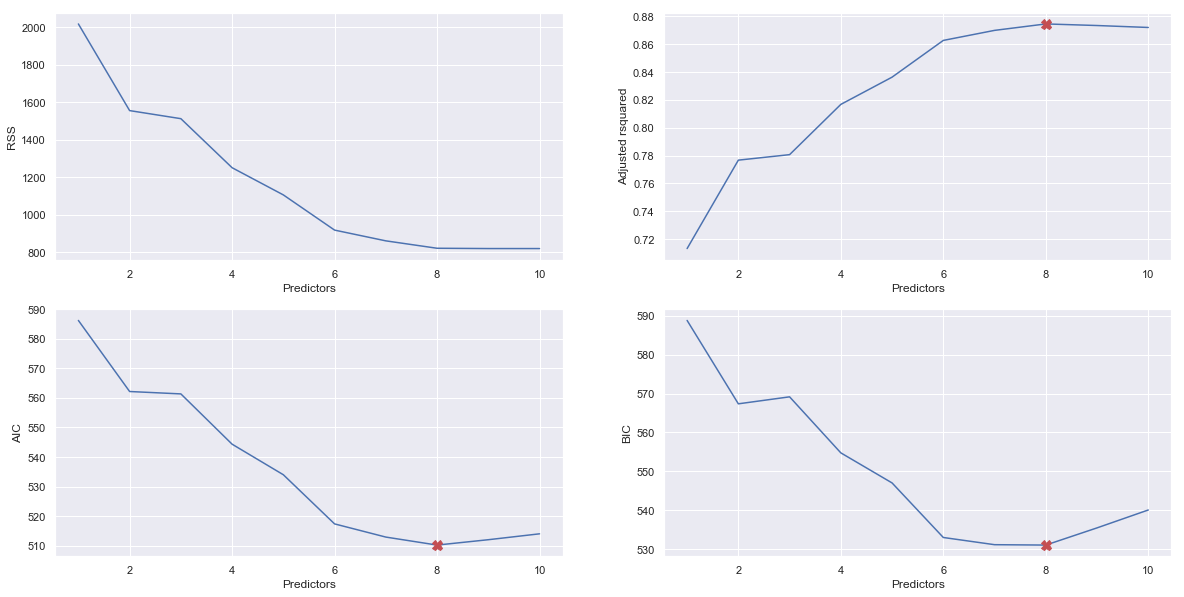

In [47]:
def plots_of_models(models):
    ##Plots
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    plt.subplot(2, 2, 1)

    plt.plot(models["RSS"])
    plt.xlabel('Predictors')
    plt.ylabel('RSS')

    rsquared_adj = models.apply(lambda col: col[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "Xr")
    plt.xlabel('Predictors')
    plt.ylabel('Adjusted rsquared')

    aic = models.apply(lambda col: col[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(aic.idxmin(), aic.min(), "Xr")
    plt.xlabel('Predictors')
    plt.ylabel('AIC')

    bic = models.apply(lambda col: col[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(bic.idxmin(), bic.min(), "Xr")
    plt.xlabel('Predictors')
    plt.ylabel('BIC')
plots_of_models(models)

In [48]:
def forward(features):
    
    # save the untouched features
    remaining_features = [f for f in X.columns if f not in features]
    
    results = []
    
    for f in remaining_features:
        results.append(select_subset(features+[f]))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].idxmin()]
    # return the best model
    return best_model

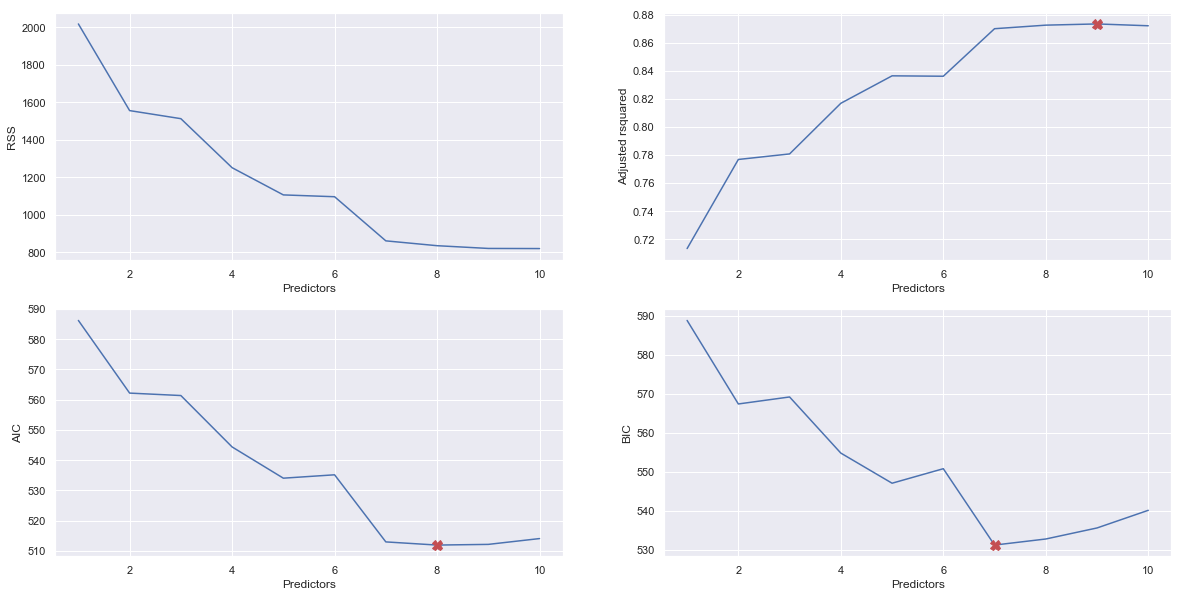

In [49]:
models_forward = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1, len(X.columns)+1):
    models_forward.loc[i] = forward(predictors)
    # will save the features one by one
    predictors = models_forward.loc[i]["model"].model.exog_names
    
    
plots_of_models(models_forward)

In [50]:
def backward(features):
    
    results = []
    
    for comb in combinations(features,len(features)-1):
        results.append(select_subset(comb))
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].idxmin()]
    
    return best_model

In [51]:
models_backward = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

features = X.columns

while(len(features) > 1):  
    models_backward.loc[len(features)-1] = backward(features)
    print(features)
    features = models_backward.loc[len(features)-1]["model"].model.exog_names

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'], dtype='object')
['X1', 'X2', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
['X2', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
['X2', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']
['X2', 'X4', 'X5', 'X6', 'X7', 'X9']
['X2', 'X4', 'X5', 'X6', 'X7']
['X2', 'X4', 'X5', 'X7']
['X2', 'X4', 'X5']
['X4', 'X5']


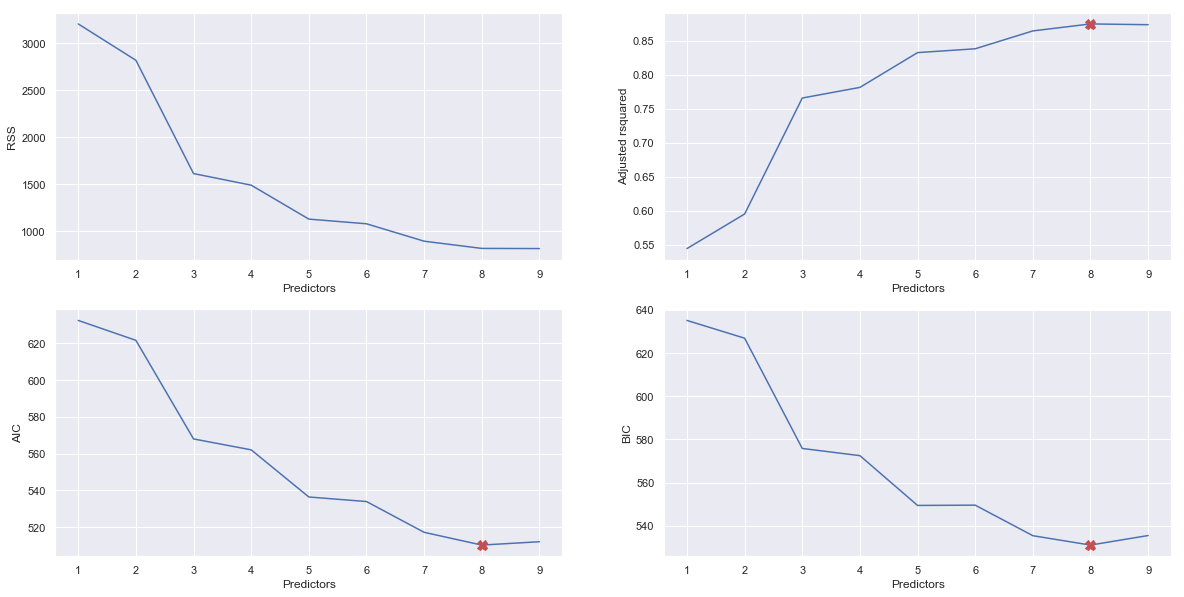

In [52]:
plots_of_models(models_backward)

In [53]:
print(models_forward.loc[7, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     96.51
Date:                Sat, 22 Feb 2020   Prob (F-statistic):           7.95e-40
Time:                        13:32:47   Log-Likelihood:                -249.46
No. Observations:                 100   AIC:                             512.9
Df Residuals:                      93   BIC:                             531.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X3             6.6096      0.674      9.811      0.0

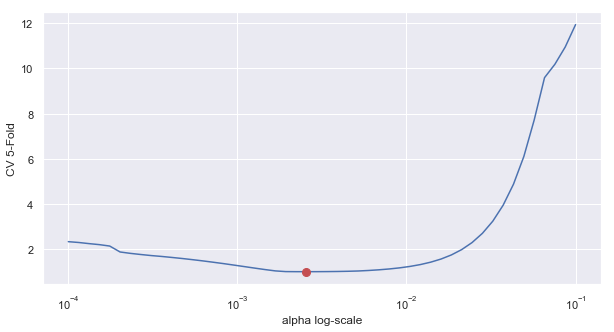

In [54]:
## e --->  the Lasso

# Use 5-fold cross validation to determine optimal alpha
lasso_cv = LassoCV(alphas = np.logspace(-4,-1,50), normalize=True, cv=5, max_iter=100000)
lasso_cv.fit(X.values, y.values)

# The mse estimates are the mean aross folds for different alphas
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lasso_cv.alphas_,mses, color='b');
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [55]:
lasso_cv.alpha_

0.002559547922699536

In [57]:
###############               9



college = pd.read_csv('data/college.csv')
college.head()


,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [60]:
#check for missing values
print(college.isna().any())


Private        False
Apps           False
Accept         False
Enroll         False
Top10perc      False
Top25perc      False
F.Undergrad    False
P.Undergrad    False
Outstate       False
Room.Board     False
Books          False
Personal       False
PhD            False
Terminal       False
S.F.Ratio      False
perc.alumni    False
Expend         False
Grad.Rate      False
dtype: bool


In [66]:
# Tansform the dummy feature private from categorical to numerical
college['Private_Yes'] = np.where(college['Private'] =="Yes",1,0)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_Yes
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1


In [68]:
# Separate the predictors
X = college.iloc[:,3:]
y = college['Apps']

# Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mean_squared_error(y_test, lr.predict(X_test))


1936484.289605969

Text(0, 0.5, 'Train Set MSE')

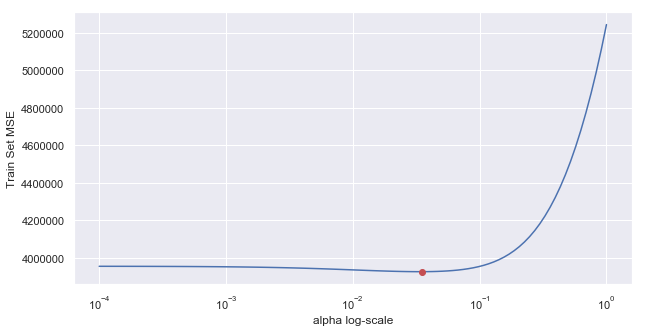

In [172]:
alphas = np.logspace(-4, 0, 100)
ridge_cv = RidgeCV(alphas = alphas, normalize=True, store_cv_values=True)
results = ridge_cv.fit(X_train.values, y_train.values)

# the results contains a np array [num_samples,num_alphas] a form of LOOCV was performed so 
# the mean(axis=0) is the average MSE for a given alpha
cvs = np.mean(results.cv_values_, axis=0)
# get the minimum error rate and the optimum alpha
min_cvs = np.min(cvs)
min_alpha = results.alpha_


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas,np.mean(results.cv_values_,axis=0), color='b')
ax.plot(min_alpha, min_cvs, color='r', marker='o',)
ax.set_xscale('log')
ax.set_xlabel('alpha log-scale')
ax.set_ylabel('Train Set MSE')

In [173]:
# Get the ridge models predictions on the test set
ridge_pred = results.predict(X_test.values)

# Get the MSE of the Ridges predictions
ridge_mse = mean_squared_error(ridge_pred, y_test)
print("The Ridge Model Test MSE = ", ridge_mse, '\n')

print(pd.Series(data = np.hstack([results.intercept_,results.coef_]), index=['Intercept'] + list(X.columns)))



The Ridge Model Test MSE =  1950958.6706469331 

Intercept     -2849.561420
Enroll            2.192248
Top10perc         9.010139
Top25perc         7.494525
F.Undergrad       0.223433
P.Undergrad      -0.023334
Outstate          0.006131
Room.Board        0.357937
Books             0.168162
Personal         -0.148787
PhD              -1.996114
Terminal         -4.654518
S.F.Ratio        12.354121
perc.alumni     -20.704655
Expend            0.099997
Grad.Rate        21.322432
Private_Yes    -493.862484
dtype: float64


Text(0, 0.5, '5-Fold CV Train MSE')

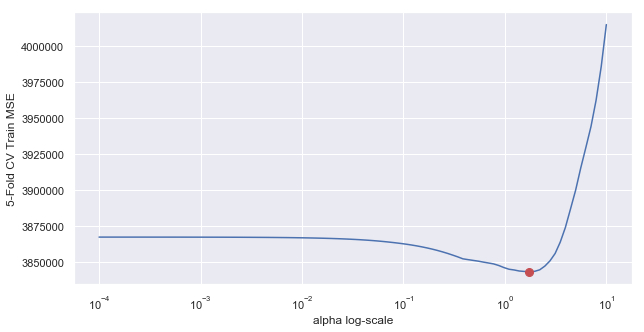

In [174]:
 ## the same for Lasso
    
lasso_cv = LassoCV(alphas = np.logspace(-4,1,100), normalize=True, cv=5, max_iter=100000)
lasso_cv.fit(X_train.values, y_train.values)

# The mse estimates are the mean aross folds
mses = np.mean(lasso_cv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lasso_cv.alphas_,mses, color='b');
ax.plot(lasso_cv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale')
ax.set_xscale('log')
ax.set_ylabel('5-Fold CV Train MSE')



In [175]:
lasso_pred = lasso_cv.predict(X_test.values)

# Get the MSE of the Ridges predictions
lasso_mse = mean_squared_error(lasso_pred, y_test)
print("The Ridge Model Test MSE = ", lasso_mse, '\n')

print(pd.Series(data = np.hstack([lasso_cv.intercept_,lasso_cv.coef_]), index=['Intercept'] + list(X.columns)))



The Ridge Model Test MSE =  1987951.6740561516 

Intercept     -2962.233856
Enroll            2.779962
Top10perc         5.641971
Top25perc         5.888252
F.Undergrad       0.118747
P.Undergrad      -0.000000
Outstate          0.000000
Room.Board        0.328062
Books             0.000000
Personal         -0.059097
PhD              -0.000000
Terminal         -0.000000
S.F.Ratio         0.000000
perc.alumni     -15.432905
Expend            0.089460
Grad.Rate        18.751796
Private_Yes    -259.033116
dtype: float64


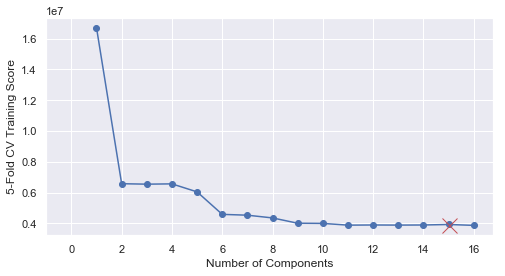

In [176]:
## PCR Model


# list to hold the cv scores
scores = []

# The number of components will variate from 1 to a maximum (all features)
nr_components = np.arange(1,len(X.columns)+1)

for n in nr_components:
    pca = PCA(n_components=n)
    
    # apply scaling, PCA, and Linear Regression in a pipeline
    pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
    
    # Fit data and append cv score
    pipeline.fit(X_train.values,y_train.values)
    scores.append(-np.mean(cross_val_score(pipeline, X_train.values, y_train.values, 
                                           scoring='neg_mean_squared_error', cv=5)))

# get the min cv score
min_score,min_index = min([(j,i) for i,j in enumerate(scores)])
    
# Plot CV scores across number of PCs   
fig, ax = plt.subplots(figsize=(8,4))
# Plot the minimum cv score and the number of PCs that give that score
ax.plot(nr_components,scores, marker='o', color='b');
ax.plot(min_index, min_score, marker='x', color='r', markersize = 15);
ax.set_xlabel('Number of Components');
ax.set_ylabel('5-Fold CV Training Score');
ax.set_xlim(xmin=-1);

The PCR indicate that the most optimal number of features is 15. 

In [163]:
pca = PCA(n_components=15)
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
pipeline.fit(X_train.values, y_train.values)
y_pred = pipeline.predict(X_test)
print("The PCR Model Test MSE = ", mean_squared_error(y_pred, y_test), '\n')


The PCR Model Test MSE =  2049909.2123200803 



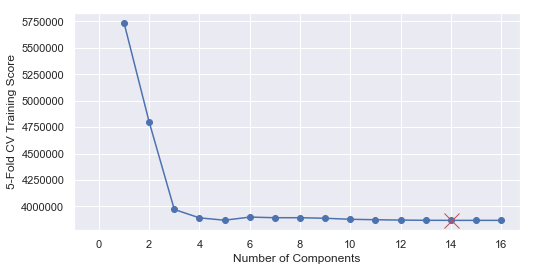

In [168]:
pls_scores = []

# Get number of components and num samples of training data
nr_components = list(np.arange(1,len(X.columns)+1))

for n in nr_components:
    # construct PLS obj with n_components
    pls = PLSRegression(n_components=n, scale=True)

    pls_scores.append(-np.mean(cross_val_score(pls, X_train.values, y_train.values, 
                                           scoring='neg_mean_squared_error', cv=5)))   
# get the min cv score and it's index
min_score,min_index = min([(j,i) for i,j in enumerate(pls_scores)])

# Plot CV scores across number of components 
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(nr_components,pls_scores, marker='o', color='b');
ax.plot(min_index, min_score, marker='x', color='r', markersize = 15);
ax.set_xlabel('Number of Components');
ax.set_ylabel('5-Fold CV Training Score');
ax.set_xlim(xmin=-1);

In [169]:
pls = PLSRegression(n_components=14, scale=True)
pls.fit(X_train.values, y_train.values)
mean_squared_error(pls.predict(X_test.values),y_test)

1936698.5067661337

In [243]:
##### 11

boston = pd.read_csv('data/boston.csv')
boston.head()
  

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [247]:
X = boston.iloc[:,1:]
y = boston['crim']

In [249]:
##OLS on full dataset
np.random.seed(0)
ols_model = LinearRegression()
ols_mse = -np.mean(cross_val_score(ols_model,X,y,
                                  scoring='neg_mean_squared_error', cv=len(boston)))

print('LOOCV Estimate of Least Squares Test MSE = ', ols_mse)


LOOCV Estimate of Least Squares Test MSE =  42.96874021592409


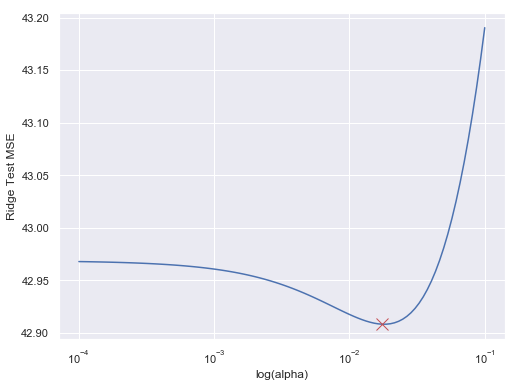

Ridge Regression LOOCV Test MSE Estimate =  42.908334949825175 



In [261]:
##Ridge 

alphas = 10**np.linspace(-4,-1, 100)
ridge = RidgeCV(alphas=alphas, fit_intercept=True, normalize=True, store_cv_values=True)
ridge.fit(X,y)

# the alpha with the minimum cv test error
ridge_mse = np.mean(ridge.cv_values_, axis=0)
min_ridge_mse,min_mse_id = min([(j,i) for i,j in enumerate(ridge_mse)])


fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot(alphas, ridge_mse)
ax1.plot(alphas[min_mse_id], min_ridge_mse, marker='x', color='r', markersize=12);
ax1.set_xscale('log');
ax1.set_xlabel('log(alpha)');
ax1.set_ylabel('Ridge Test MSE');
plt.show()

# Print the Ridge's Test MSE at the optimal alpha
print('Ridge Regression LOOCV Test MSE Estimate = ', min_ridge_mse,'\n')


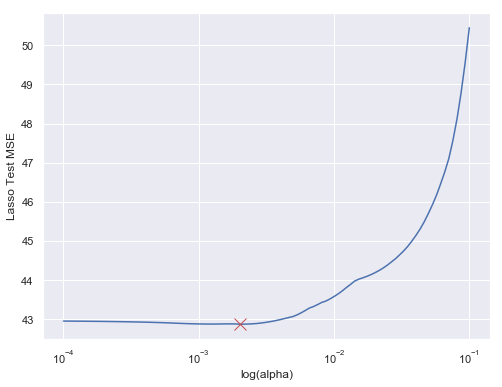

Lasso Regression LOOCV Test MSE Estimate =  42.877918668640014 



In [262]:
alphas = 10**np.linspace(-4,-1, 100)
lasso = LassoCV(alphas=alphas, fit_intercept=True, normalize=True, cv=len(boston))
lasso.fit(X,y)

lasso_mse = np.mean(lasso.mse_path_, axis=1)
min_lasso_mse = min(lasso_mse)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lasso.alphas_, lasso_mse )
ax.plot(lasso.alpha_, min_lasso_mse, marker='x', color='r', markersize=12);
ax.set_xscale('log');
ax.set_xlabel('log(alpha)');
ax.set_ylabel('Lasso Test MSE');
plt.show()

print('Lasso Regression LOOCV Test MSE Estimate = ', min(lasso_mse),'\n')

By modeling the full dataset it can be noticed that Ridge and Lasso show better results than OLS.This means that there are certain challenges for the OLS model, such as high correlation between the predictiors. The correlation matrix confirms this assumption. The correlation between tax and rad is 0.91, dis and nox is -0.769. Also non-linearity of the data can make the regularization useless. 

In [263]:
boston.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
zn,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
indus,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
chas,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
nox,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
rm,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
age,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
dis,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
rad,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
tax,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Text(0, 0.5, 'Residuals')

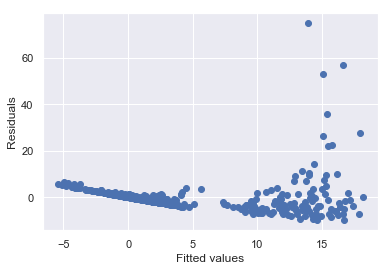

In [265]:
model = sm.OLS(y, sm.add_constant(X)).fit()


fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(model.fittedvalues.values, model.resid.values, edgecolors='b');
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')

The U-shape of the residuals confirms the non-linearity between X and y, where the residuals increases with the fitted values. A better model would should improve the non-linearity of the predictors, so that the residuals would not have outliners.